## Competiton Introduction

**TL;DR:** <br> 
The Titanic Kaggle Competition challenges you to predict which passengers survived the Titanic disaster. We will use provided data (like age, sex, and passenger class) to train a machine learning model. <br>The goal is to accurately predict survival on a separate test dataset. This involves data preprocessing, data analysis, feature engineering, and model evaluation to maximize prediction accuracy.

#### Goal<br>
The primary goal of this project is to practice and reinforce machine learning skills by applying the methods and techniques learned in class. Specifically, we aim to:

- Practice using different libraries and creating various plots to enhance our data visualization skills.
- Implement and refine various machine learning algorithms and pipelines.
- Apply appropriate preprocessing steps to prepare the data for modeling.
- Utilize model evaluation and tuning techniques to optimize model performance.
- Strive to achieve the highest possible score on the given dataset.


## Project imports

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline



# Data Preprocessing

Firstly, we will load the data using 'pandas' library, in the goal of getting some general info about the data and features we've got

In [45]:
filenames = ['train.csv', 'test.csv']
dataArray = []
for filename in filenames:
    df = pd.read_csv(filename)
    dataArray.append(df)

train_data = dataArray[0]
test_data = dataArray[1]
test_ids = test_data['PassengerId']

In [46]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Handling Missing and duplicate values

As we saw 2 cells above, there are some missing values in our data.. so we'll firstly handle that.

In [48]:
#Count Duplicates values
print("Number of duplicates records in train_data: ", train_data.duplicated().sum())

Number of duplicates records in train_data:  0


In [49]:
def summarize_missing_values(df):
    """
    This function takes a DataFrame as input and returns a summary DataFrame
    that includes the column types, the count of missing values, and the percentage
    of missing values for each column.
    """
    # Calculate total missing values for each column
    total_missing = df.isnull().sum()

    # Get data types for each column
    column_types = df.dtypes

    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Column Type': column_types,
        'Missing Values': total_missing,
        'Percentage Missing %': round((total_missing / df.shape[0]) * 100, 4)
    })

    return summary

In [50]:
print(f"Training missing values:\n{summarize_missing_values(train_data)}")

Training missing values:
            Column Type  Missing Values  Percentage Missing %
PassengerId       int64               0                0.0000
Survived          int64               0                0.0000
Pclass            int64               0                0.0000
Name             object               0                0.0000
Sex              object               0                0.0000
Age             float64             177               19.8653
SibSp             int64               0                0.0000
Parch             int64               0                0.0000
Ticket           object               0                0.0000
Fare            float64               0                0.0000
Cabin            object             687               77.1044
Embarked         object               2                0.2245


In [51]:
print(f"Test missing values:\n{summarize_missing_values(test_data)}")

Test missing values:
            Column Type  Missing Values  Percentage Missing %
PassengerId       int64               0                0.0000
Pclass            int64               0                0.0000
Name             object               0                0.0000
Sex              object               0                0.0000
Age             float64              86               20.5742
SibSp             int64               0                0.0000
Parch             int64               0                0.0000
Ticket           object               0                0.0000
Fare            float64               1                0.2392
Cabin            object             327               78.2297
Embarked         object               0                0.0000


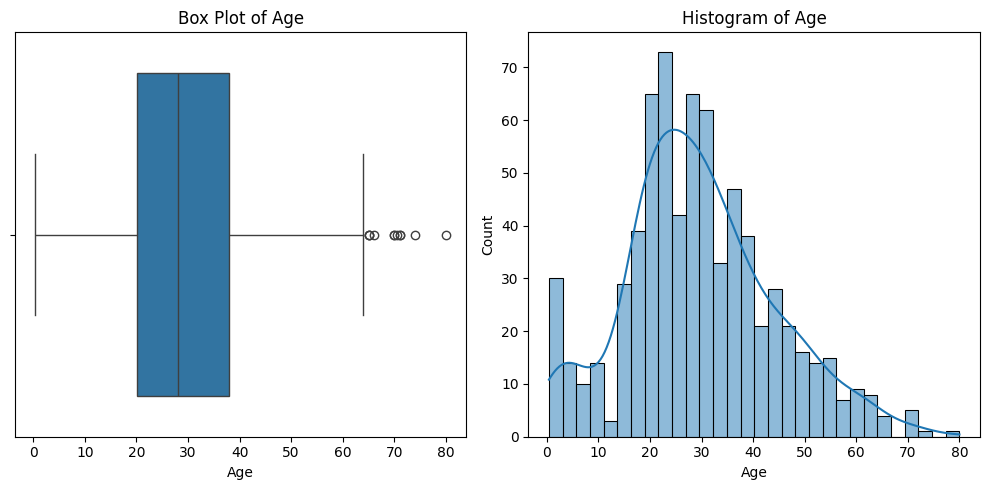

In [52]:
# Box plot to show outliers
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=train_data['Age'])
plt.title('Box Plot of Age')

# Histogram to show the distribution
plt.subplot(1, 2, 2)
sns.histplot(train_data['Age'], bins=30, kde=True)
plt.title('Histogram of Age')
plt.xlabel('Age')

plt.tight_layout()
plt.show()

This plot shows that there are some outliers in the Age column. So we will prefer to replace the missing 'Age' values with the median value of the column. same with the 'Fare' missing values.

In [53]:
#Handle Missing Numerical values: Fill with the median of the column
train_data.loc[:, 'Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data.loc[:, 'Age'] = test_data['Age'].fillna(test_data['Age'].median())
test_data.loc[:, 'Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

For the 'Embarked' Categorial feature, we will replace it with the most common value

In [54]:
#Handle Missing Categorical values : Fill with the mode of the column
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
test_data['Embarked'] = test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])

### Remove hindering features<br>
**Cabin**: 78% of training data don't have this feature.<br>
**PassengerId**: Meaningless integer.<br>
**Name** : String like object that has little to no impact on the prediction.<br>
**Ticket**: Unnecessary and hard to process feature.

In [55]:
def drop_features(train_df, test_df, features_to_remove):
    """
    This function removes specified features from both the training and test DataFrames.

    Returns:
    The preprocessed training DataFrame.
    The preprocessed test DataFrame.
    """
    train_df_processed = train_df.drop(columns=features_to_remove, axis=1)
    test_df_processed = test_df.drop(columns=features_to_remove, axis=1)

    return train_df_processed, test_df_processed

#Remove specified features from our datasets.
train_data , test_data = drop_features(train_data , test_data,['Cabin','PassengerId','Name','Ticket'])


In [56]:
#Make sure there are no more missing values
test_data.isnull().sum(), train_data.isnull().sum()

(Pclass      0
 Sex         0
 Age         0
 SibSp       0
 Parch       0
 Fare        0
 Embarked    0
 dtype: int64,
 Survived    0
 Pclass      0
 Sex         0
 Age         0
 SibSp       0
 Parch       0
 Fare        0
 Embarked    0
 dtype: int64)

### Encode the categorical features

In [57]:
def OneHotEncodeDF(train_df, test_df):
    """
    This function takes a training DataFrame and a test DataFrame as input, identifies the categorical columns,
    applies one-hot encoding to them using the training data, and returns new DataFrames with the encoded columns

    Returns:
    pd.DataFrame: The encoded training DataFrame.
    pd.DataFrame: The encoded test DataFrame.
    """
    # Extract the columns with object datatype as they are the categorical columns
    categorical_columns = train_df.select_dtypes(include=['object']).columns.tolist()

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit the encoder on the training data
    encoder.fit(train_df[categorical_columns])

    # Apply one-hot encoding to the training data
    train_one_hot_encoded = encoder.transform(train_df[categorical_columns])

    # Apply one-hot encoding to the test data
    test_one_hot_encoded = encoder.transform(test_df[categorical_columns])

    # Create DataFrames with the one-hot encoded columns
    train_one_hot_df = pd.DataFrame(train_one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
    test_one_hot_df = pd.DataFrame(test_one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

    # Concatenate the one-hot encoded dataframe with the original dataframe
    train_df_encoded = pd.concat([train_df.reset_index(drop=True), train_one_hot_df], axis=1)
    test_df_encoded = pd.concat([test_df.reset_index(drop=True), test_one_hot_df], axis=1)

    # Drop the original categorical columns
    train_df_encoded = train_df_encoded.drop(categorical_columns, axis=1)
    test_df_encoded = test_df_encoded.drop(categorical_columns, axis=1)

    return train_df_encoded, test_df_encoded


In [58]:
#Encode the dataframes
train_data, test_data = OneHotEncodeDF(train_data, test_data)
train_data.head(7)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0
5,0,3,28.0,0,0,8.4583,0.0,1.0,0.0,1.0,0.0
6,0,1,54.0,0,0,51.8625,0.0,1.0,0.0,0.0,1.0



# EDA- Exploratory  Data Analysis

We will want to explore and analyze the data to find patterns, correlations and connections between different features, and between features and the target label.<br>
We'll start by calculating the **survival rate**.

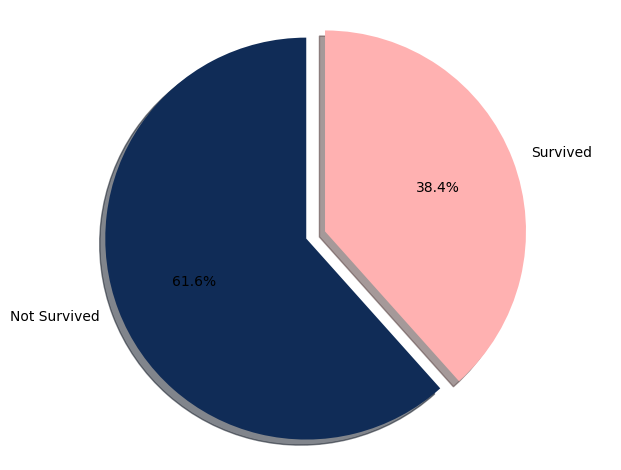

In [59]:
# Calculate survival rate
survival_rate = train_data.Survived.value_counts(normalize=True) * 100

# Labels and sizes
labels = ['Not Survived', 'Survived']
sizes = [survival_rate[0], survival_rate[1]]
colors = ['#102C57', '#FFB1B1']

# Explode setting for pie chart
explode = (0, 0.1)  # Only "explode" the 2nd slice (i.e. 'Not Survived')

# Create the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, colors=colors, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

Next, we wanna visualize the connection between some features and the survival rate, hoping to gain some insights. <br>starting with the **'Age'** feature

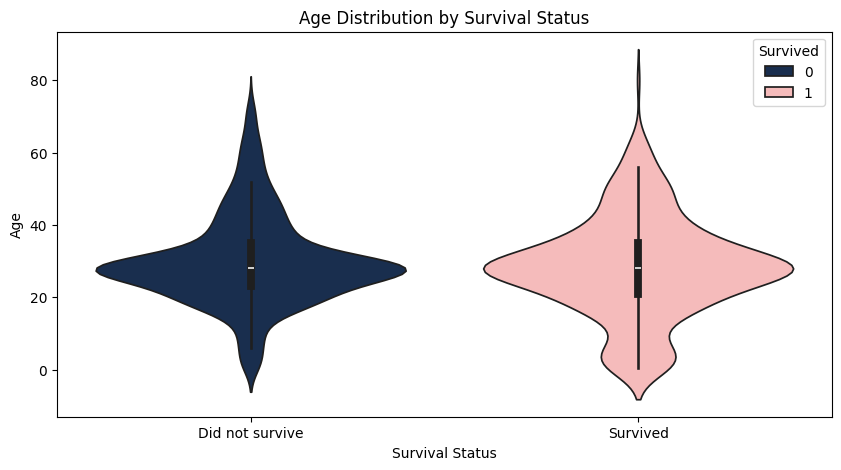

In [60]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='Survived', y='Age',hue='Survived', data=train_data, palette=['#102C57', '#FFB1B1'])

plt.title('Age Distribution by Survival Status')
plt.xlabel('Survival Status')
plt.ylabel('Age')
plt.xticks([0, 1], ['Did not survive', 'Survived'])

plt.show()

The age distribution plots for survivors and non-survivors suggest a low correlation between age and survival. Both groups exhibit pretty similar distributions.
<br>**In Conclusion**: survival outcomes are likely influenced by other factors besides age alone.

Next, we wanna find some connection of the passengers **class** and the survival rate:

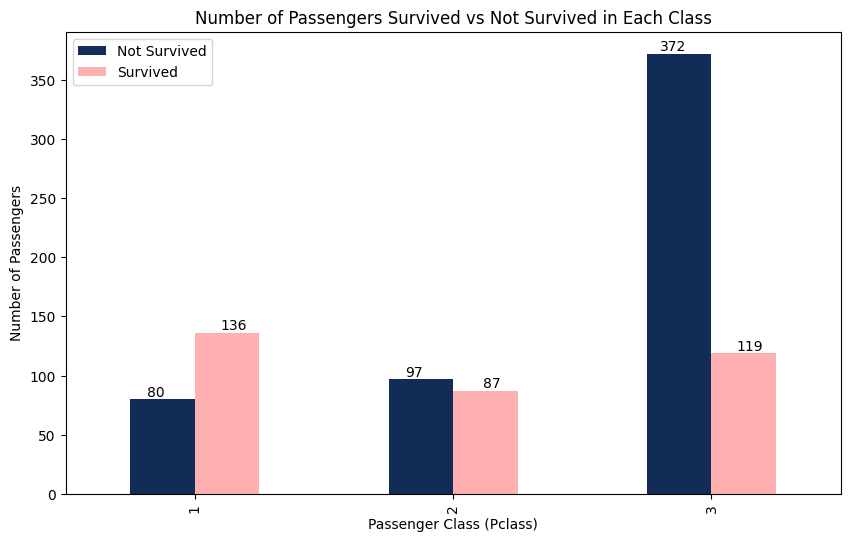

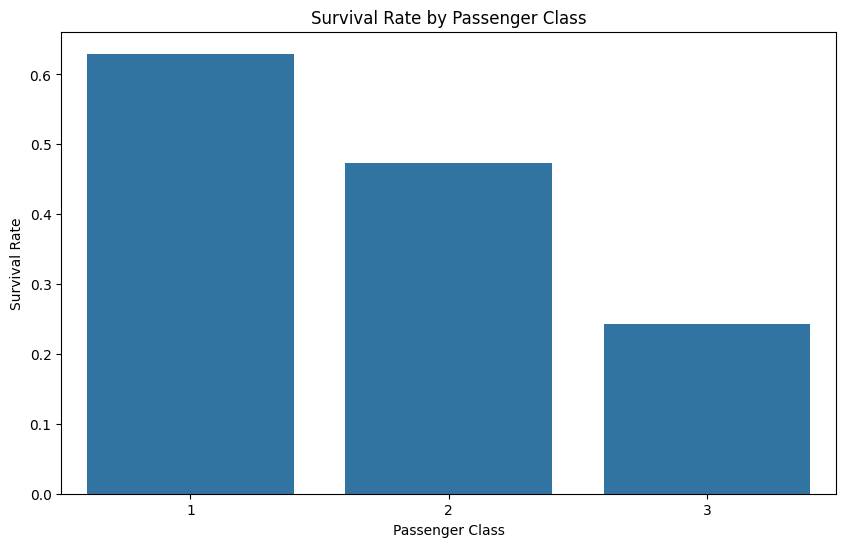

In [61]:
survived_counts = train_data[train_data['Survived'] == 1]['Pclass'].value_counts().sort_index()
not_survived_counts = train_data[train_data['Survived'] == 0]['Pclass'].value_counts().sort_index()

# Combine the counts into a DataFrame
counts_df = pd.DataFrame({
    'Not Survived': not_survived_counts,
    'Survived': survived_counts
})

# Create a grouped bar plot for the counts
counts_df.plot(kind='bar', figsize=(10, 6), color = ['#102C57', '#FFB1B1'])

# Adding titles and labels
plt.title('Number of Passengers Survived vs Not Survived in Each Class')
plt.xlabel('Passenger Class (Pclass)')
plt.ylabel('Number of Passengers')

# Annotating the bar chart with counts
for i in range(len(counts_df)):
    plt.text(i - 0.15, counts_df.iloc[i, 0], str(counts_df.iloc[i, 0]), ha='center', va='bottom')
    plt.text(i + 0.15, counts_df.iloc[i, 1], str(counts_df.iloc[i, 1]), ha='center', va='bottom')

# Show the plot
plt.show()

# Calculate the ratio of passengers that survived in each class
survival_ratio = train_data.groupby('Pclass')['Survived'].mean()
#we will plot the ratio of passengers that survived in each class
plt.figure(figsize=(10, 6))
sns.barplot(x=survival_ratio.index, y=survival_ratio.values)
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()


As we can see, Class 1 passengers has much higher survival rate than the second class and more than double survival chances than those poor passengers at the third class.. :(

**Fare** also might help up understand more- based on the hypothesis/assumption that higher fare may be correlated with higher Pclass which did gave us some insights as we saw above

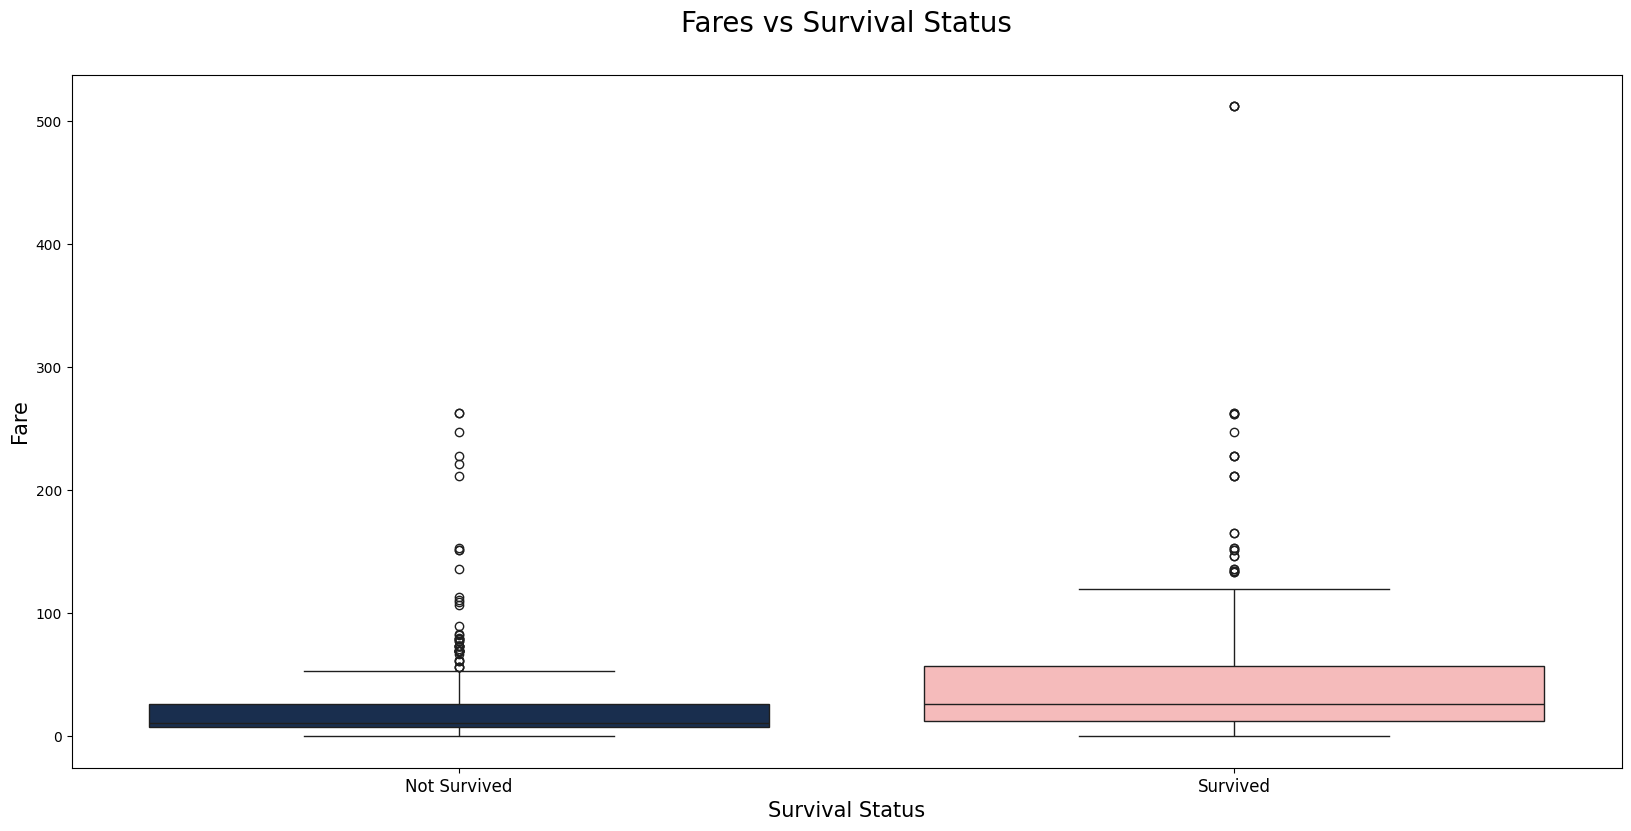

In [62]:
plt.figure(figsize=(20, 9))
sns.boxplot(x='Survived', y='Fare', hue='Survived', data=train_data, palette=['#102C57','#FFB1B1'], dodge=False, legend=False)

plt.xlabel('Survival Status', size=15)
plt.ylabel('Fare', size=15)
plt.xticks([0, 1], ['Not Survived', 'Survived'], size=12)  # Explicitly set x-tick labels for clarity
plt.title('Fares vs Survival Status', size=20, y=1.05)

plt.show()

As we can notice at the bar distribution plot above, the fare range of those who survived is slightly higher, which may suggest some correlation between higher fare and survival rate.

## Correlation Matrix

Next, we will show the correlation matrix of the features in the dataset to get some additional important info

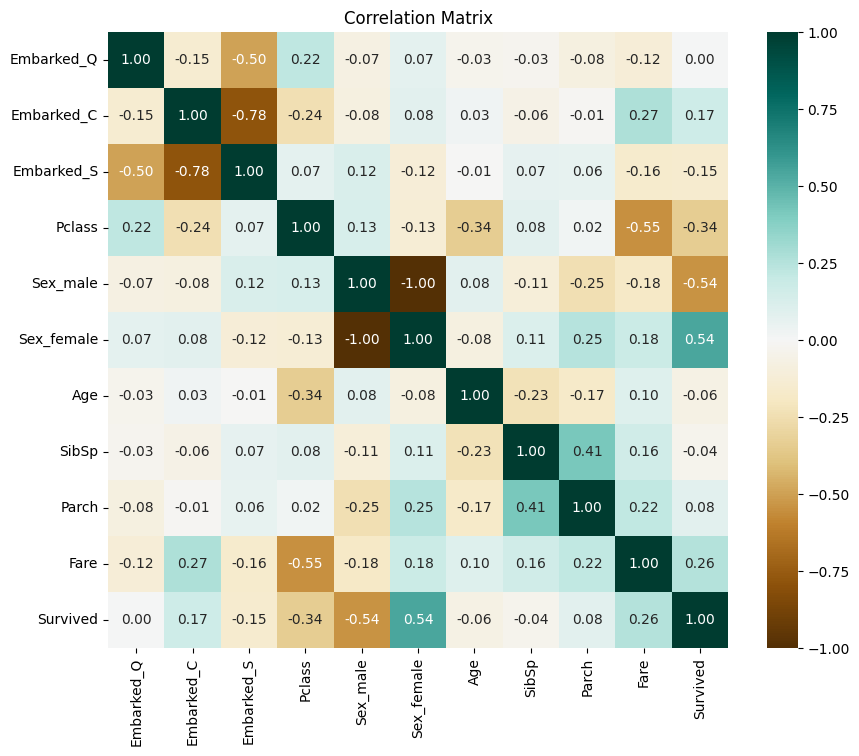

In [63]:
corr_matrix = train_data[['Embarked_Q','Embarked_C','Embarked_S','Pclass', 'Sex_male','Sex_female', 'Age', 'SibSp', 'Parch', 'Fare','Survived']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr_matrix, annot=True, cmap='BrBG', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In the correlation matrix we see that the correlation of female feature and survived label is opposite from the correlation of male and survived label (0.54 and -0.54).<br>
This hints us to further investigate the connections between 'Sex' and survival rate. 


**Note: That also may align well with the well known hypothesis of 'Women and Children First'.<br>although it might be just a 'myth' as we futher investigated and found that: https://www.cbsnews.com/news/women-and-children-first-just-a-myth-researchers-say/.

In [64]:
def as_percent(val, precision='0.2'):
    """Convert number to percentage string."""
    if isinstance(val):
        return "{{:{}%}}".format(precision).format(val)
    else:
        raise TypeError("Numeric type required")

def calculate_percentage(val, total, format_percent = False):
    """Calculates the percentage of a value over a total"""
    percent = np.divide(val, total, dtype=float)
    if format_percent:
        percent = as_percent(percent)
    return percent

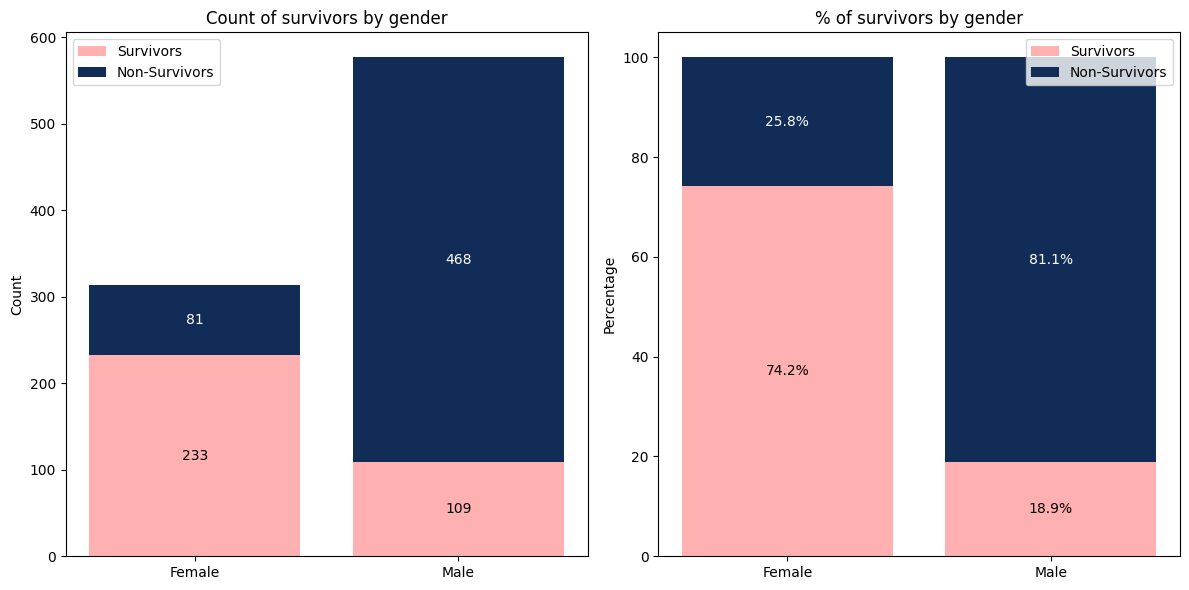

In [65]:
# Calculate counts for survivors and non-survivors by gender
survived_counts = train_data[train_data['Survived'] == 1].groupby('Sex_male').size().values
not_survived_counts = train_data[train_data['Survived'] == 0].groupby('Sex_male').size().values

# Calculate totals for percentages
totals = survived_counts + not_survived_counts

# Calculate percentages
survived_percentages = calculate_percentage(survived_counts, totals) * 100
not_survived_percentages = calculate_percentage(not_survived_counts, totals) * 100

# Define categories
gender_categories = ['Female', 'Male']

# Plotting setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for count of survivors by gender
ax1.bar(gender_categories, survived_counts, label='Survivors', color='#FFB1B1')
ax1.bar(gender_categories, not_survived_counts, bottom=survived_counts, label='Non-Survivors', color='#102C57')
ax1.set_ylabel('Count')
ax1.set_title('Count of survivors by gender')
ax1.legend()

# Annotate counts
for i, (survived, not_survived) in enumerate(zip(survived_counts, not_survived_counts)):
    ax1.annotate(f'{survived}', xy=(i, survived / 2), ha='center', va='center')
    ax1.annotate(f'{not_survived}', xy=(i, survived + not_survived / 2), ha='center', va='center', color='white')

# Plot for percentage of survivors by gender
ax2.bar(gender_categories, survived_percentages, label='Survivors', color='#FFB1B1')
ax2.bar(gender_categories, not_survived_percentages, bottom=survived_percentages, label='Non-Survivors', color='#102C57')
ax2.set_ylabel('Percentage')
ax2.set_title('% of survivors by gender')
ax2.legend()

# Annotate percentages
for i, (survived_pct, not_survived_pct) in enumerate(zip(survived_percentages, not_survived_percentages)):
    ax2.annotate(f'{survived_pct:.1f}%', xy=(i, survived_pct / 2), ha='center', va='center')
    ax2.annotate(f'{not_survived_pct:.1f}%', xy=(i, survived_pct + not_survived_pct / 2), ha='center', va='center', color='white')

# Show plot
plt.tight_layout()
plt.show()

### Insights<br>
* Though the count of total male passenger is almost double than the count of total female passengers, we found that the amount of female survivors is double than the male survivors in the training set. 
This is the strongest correlation in the data set.<br>
* The correlation between Pclass and Survived is a weak negative (-0.34). Implying that as Pclass increased, the chance of survival decreased. 
The meaning of this is that passengers of higher socio-economic class had slightly better chances of survival than those of lower classes.


## Feature Engineering

Our next step will be optimizing the model by adding new features, we will start by adding the Family_size feature.


Family_Size is created by adding SibSp, Parch and 1. <br>SibSp is the count of siblings and spouse, and Parch is the count of parents and children. Those columns are added in order to find the total size of families.<br> Adding 1 at the end, is the current passenger. 

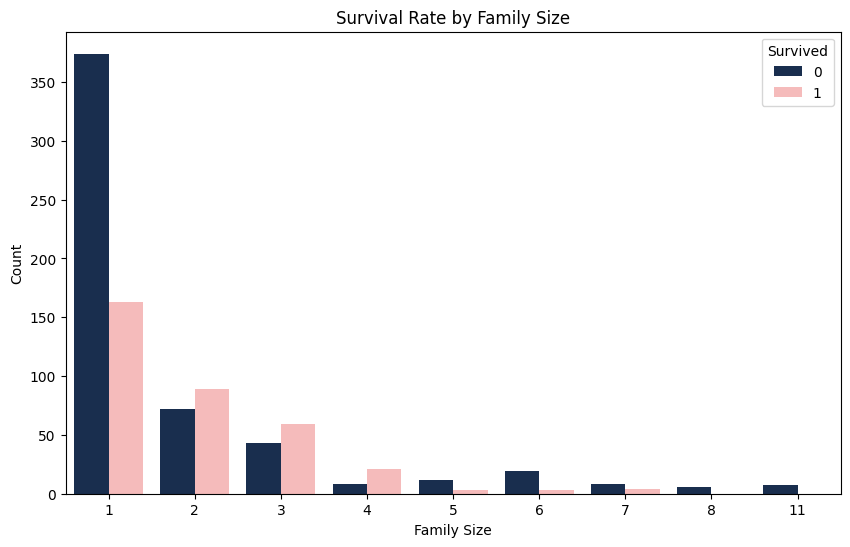

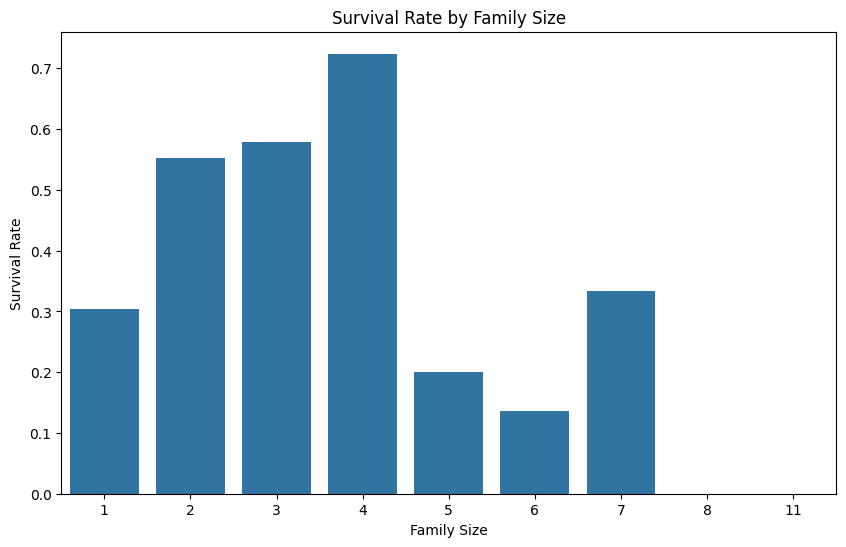

In [66]:
train_data['Family_size'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['Family_size'] = test_data['SibSp'] + test_data['Parch'] + 1

# Plot the Family_size vs survival rate hypothesis
fig, axs = plt.subplots(figsize=(10, 6))
sns.countplot(x='Family_size', hue='Survived', data=train_data, palette={0: '#102C57', 1: '#FFB1B1'})
axs.set_title('Survival Rate by Family Size')
axs.set_xlabel('Family Size')
axs.set_ylabel('Count')
plt.show()

# Clculate the ratio of passengers that survived in each family size
survival_ratio = train_data.groupby('Family_size')['Survived'].mean()
# plot the ratio of passengers that survived in each family size
plt.figure(figsize=(10, 6))
sns.barplot(x=survival_ratio.index, y=survival_ratio.values)
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate')
plt.show()

As we can see on the graph above, Family size increase the survival rate from 1-4 and then it falls dramatically, interesting. **Maybe** it has connection to some technical aspect on the rescue ships like the lifeboat capacity Or it is affected by Social dynamics / Something else / none of them .. 

In [67]:
# Drop the SibSp and Parch columns
train_data = train_data.drop(['SibSp', 'Parch'], axis=1)
test_data = test_data.drop(['SibSp', 'Parch'], axis=1)
train_data.head()

,Survived,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Family_size
0,0,3,22.0,7.2500,0.0,1.0,0.0,0.0,1.0,2
1,1,1,38.0,71.2833,1.0,0.0,1.0,0.0,0.0,2
2,1,3,26.0,7.9250,1.0,0.0,0.0,0.0,1.0,1
3,1,1,35.0,53.1000,1.0,0.0,0.0,0.0,1.0,2
4,0,3,35.0,8.0500,0.0,1.0,0.0,0.0,1.0,1


After we have added the Family_size column, we can drop the SibSp and Parch columns from the datasets.

# Building ML Model

### Splitting the Data

70% Train and 30% validation yield the best results for us.

In [68]:
#Split the train dataset into train and validation sets.
# 70% train , 30% validation.
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42)

### Building different models
All the data is being standardized using StandardScaler.

>##### SGD Classifier tuned with GridSearchCV

In [69]:
#Extract the best parameters for the model
param_grid = {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
sgd_model = SGDClassifier(loss='log_loss', random_state=42)
pipelineSGD = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', sgd_model)] )
sgd_gscv = GridSearchCV(pipelineSGD, param_grid, cv=5, scoring='accuracy')
sgd_gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        SGDClassifier(loss='log_loss',
                                                      random_state=42))]),
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                          100]},
             scoring='accuracy')

In [70]:
# Display the best parameters and best score
print("Best parameters found: ", sgd_gscv.best_params_)
print("SGD accuracy: ", sgd_gscv.best_score_)

Best parameters found:  {'model__alpha': 0.1}
SGD accuracy:  0.7993419354838711


>##### Logistic Regression

In [71]:
#Logistic Regression Model
pipeline_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression())
])
pipeline_logreg.fit(X_train ,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression())])

>##### Logistic Regression model tuned with GridSearchCV

In [72]:
params = {
    'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
    'log_reg__penalty': ['l2', 'l1'],
    'log_reg__solver': ['liblinear', 'saga'],
    'log_reg__max_iter': [100, 200, 500]
}

gscv_log_reg = GridSearchCV(pipeline_logreg, params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, return_train_score=True)
gscv_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
                         'log_reg__max_iter': [100, 200, 500],
                         'log_reg__penalty': ['l2', 'l1'],
                         'log_reg__solver': ['liblinear', 'saga']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [73]:
print(f"best parameters: {gscv_log_reg.best_params_}")
print("Logistic Regression accuracy: ", gscv_log_reg.best_score_)

best parameters: {'log_reg__C': 1, 'log_reg__max_iter': 100, 'log_reg__penalty': 'l1', 'log_reg__solver': 'saga'}
Logistic Regression accuracy:  0.8025290322580647


# Evaluating The Models

##### Graphs of training and validation log loss and accuracy as a function of the different cross-validated folds, based on the best fitting model of Logistic Regression.<br>
* We found a LogReg model with the best hyperparameters that gave the best results.<br>
* Next, applying StratifiedKFold, we use the model to evaluate its accuracy and log loss for each of the folds that it was trained and validated on.<br>
* Plot the results. Each index resembles a different fold, totalling with 5 indices.




In [74]:
# We will use stratified k-fold cross-validation to evaluate the model
from sklearn.model_selection import StratifiedKFold


def plot_loss_and_accuracy(gscv_log_reg, X, y):
    # Extract the best estimator from the GridSearchCV object
    best_estimator = gscv_log_reg.best_estimator_
    
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=gscv_log_reg.cv)
    
    # Initialize lists to store metrics
    train_accuracies = []
    val_accuracies = []
    train_CEs = []
    val_CEs = []
    
    # Perform manual cross-validation
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Fit the model on the training set
        best_estimator.fit(X_train, y_train)
        
        # Predict probabilities
        train_probs = best_estimator.predict_proba(X_train)
        val_probs = best_estimator.predict_proba(X_val)
        
        # Predict classes
        train_preds = best_estimator.predict(X_train)
        val_preds = best_estimator.predict(X_val)
        
        # Calculate accuracy
        train_accuracy = accuracy_score(y_train, train_preds)
        val_accuracy = accuracy_score(y_val, val_preds)
        
        # Calculate cross-entropy loss
        train_CE = log_loss(y_train, train_probs)
        val_CE = log_loss(y_val, val_probs)
        
        # Append the metrics
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_CEs.append(train_CE)
        val_CEs.append(val_CE)
    
    # Plotting Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(len(val_accuracies)), val_accuracies, label='Val Accuracy', color='blue', linestyle='dashed')
    plt.xlabel('Fold Index')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xticks(range(1, len(train_accuracies) + 1))  # Set x-axis to have numbers from 1 to the number of splits

    plt.legend()
    plt.show()
    
    # Plotting Cross-Entropy Loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_CEs)), train_CEs, label='Train Cross-Entropy Loss', color='red')
    plt.plot(range(len(val_CEs)), val_CEs, label='Val Cross-Entropy Loss', color='red', linestyle='dashed')
    plt.xlabel('Fold Index')
    plt.ylabel('Cross-Entropy Loss')
    plt.xticks(range(1, len(train_CEs) + 1))  # Set x-axis to have numbers from 1 to the number of splits

    plt.title('Train and Validation Cross-Entropy Loss')
    plt.legend()
    plt.show()



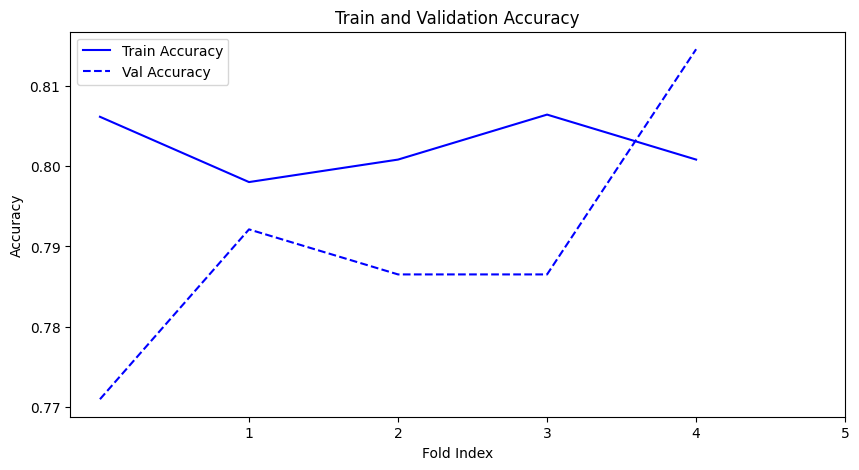

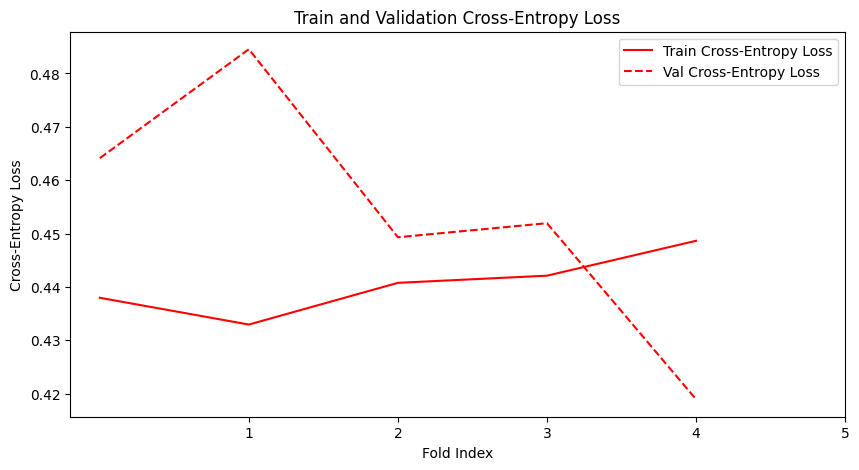

In [75]:
plot_loss_and_accuracy(gscv_log_reg, X.values, y.values)

Repeat the process for SGDClassifier


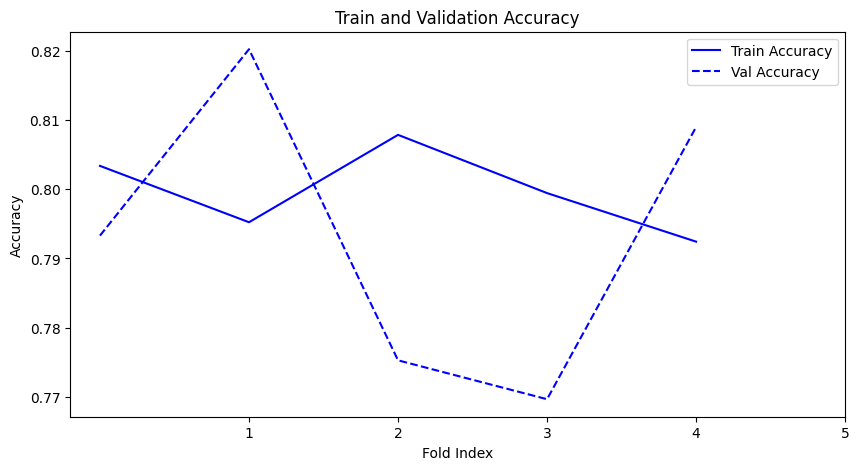

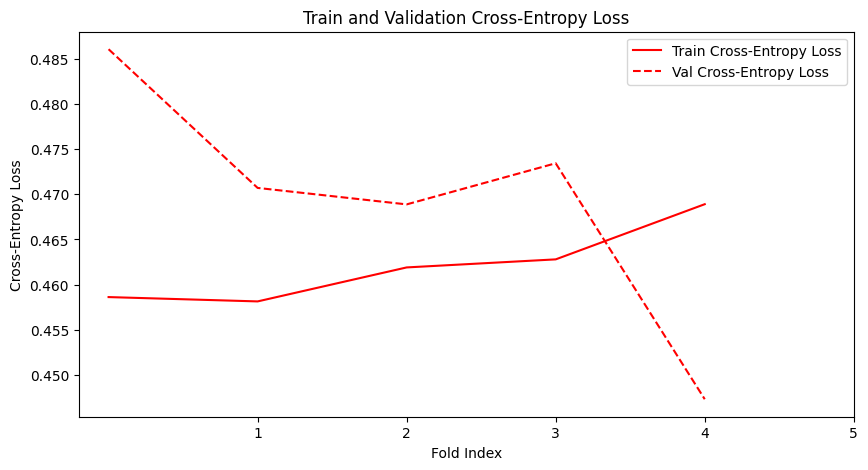

In [76]:
plot_loss_and_accuracy(sgd_gscv, X.values, y.values )

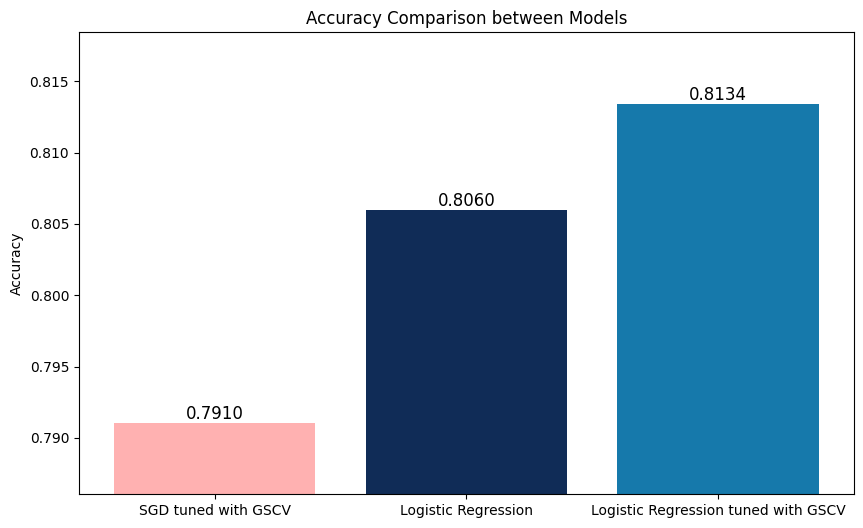

In [77]:
#Accuracy comparison bar plot for SGD, Logisic regression and Logistic regression with GridSearchCV
models = ['SGD tuned with GSCV', 'Logistic Regression', 'Logistic Regression tuned with GSCV']
accuracies = [
    accuracy_score(y_val, sgd_gscv.predict(X_val.values)),
    accuracy_score(y_val, pipeline_logreg.predict(X_val)),
    accuracy_score(y_val, gscv_log_reg.predict(X_val.values))
]

# Determine the min and max accuracy values
min_accuracy = min(accuracies)
max_accuracy = max(accuracies)

# Set y-axis limits slightly below min and above max accuracy
y_min = min_accuracy - 0.005  # Adjust this value as needed
y_max = max_accuracy + 0.005  # Adjust this value as needed

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#FFB1B1', '#102C57', '#1679AB'])
plt.ylim(y_min, y_max)
plt.title('Accuracy Comparison between Models')
plt.ylabel('Accuracy')

# Add the exact number above each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.4f}', 
             ha='center', va='bottom', fontsize=12, color='black')


plt.show()

In [78]:

def plot_confusion_matrix(model, X_val, y_val, class_labels=None, title='Confusion Matrix'):
    """
    Plots a normalized confusion matrix for the given model and validation data.

    Parameters:
    - model: The trained model to use for predictions.
    - X_val: The validation features.
    - y_val: The validation labels.
    - class_labels: Optional list of class labels for the confusion matrix. Default is None.
    - title: Title of the confusion matrix plot. Default is 'Confusion Matrix'.
    """
    # Make predictions on the validation set
    y_preds = model.predict(X_val.values)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_val, y_preds, normalize='true')
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False, 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


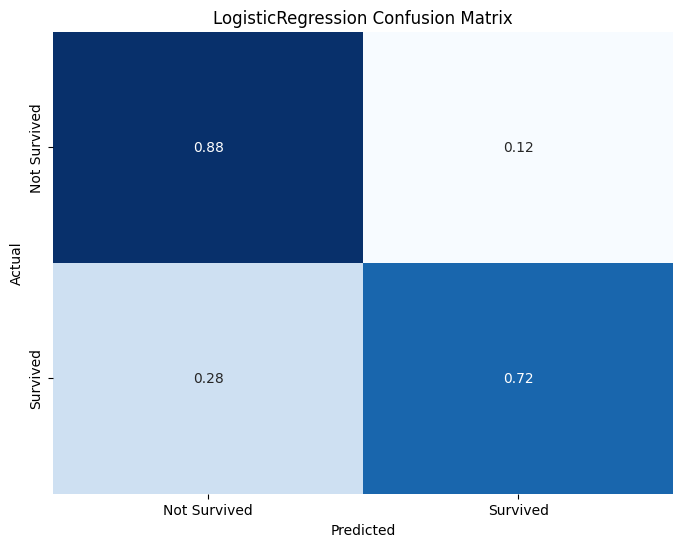

In [79]:
plot_confusion_matrix(gscv_log_reg, X_val, y_val, class_labels=['Not Survived', 'Survived'], title='LogisticRegression Confusion Matrix')

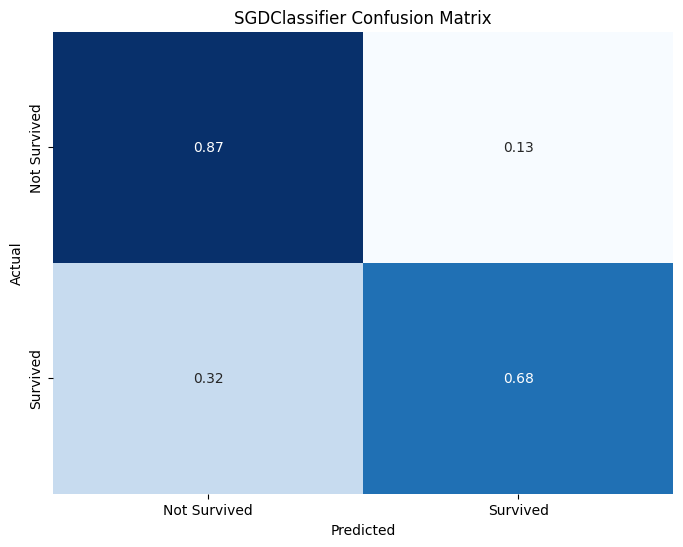

In [80]:
plot_confusion_matrix(sgd_gscv, X_val, y_val, class_labels=['Not Survived', 'Survived'], title='SGDClassifier Confusion Matrix')

In [81]:
sgd_preds = sgd_gscv.predict(X_val.values)
logreg_preds = gscv_log_reg.predict(X_val.values)

print(f'SGD Classifier report:\n{classification_report(sgd_preds, y_val)}\n\n\n')
print(f'Logistic Regression report:\n{classification_report(logreg_preds, y_val)}' )

SGD Classifier report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       171
           1       0.68      0.78      0.73        97

    accuracy                           0.79       268
   macro avg       0.78      0.79      0.78       268
weighted avg       0.80      0.79      0.79       268




Logistic Regression report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       169
           1       0.72      0.81      0.76        99

    accuracy                           0.81       268
   macro avg       0.80      0.81      0.80       268
weighted avg       0.82      0.81      0.82       268



# Submission

In [82]:
#Make preditions on the test dataset
submission_preds = pipeline_logreg.predict(test_data)
submission_preds_gcsv = gscv_log_reg.predict(test_data.values)
submission_preds_gridsearch = sgd_gscv.predict(test_data.values)

In [83]:
#Prepare dataframe for submission
submission_df = pd.DataFrame({"PassengerId": test_ids,
                              "Survived" : submission_preds_gcsv})
submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [84]:
submission_df.to_csv("submission22.csv", index=False)

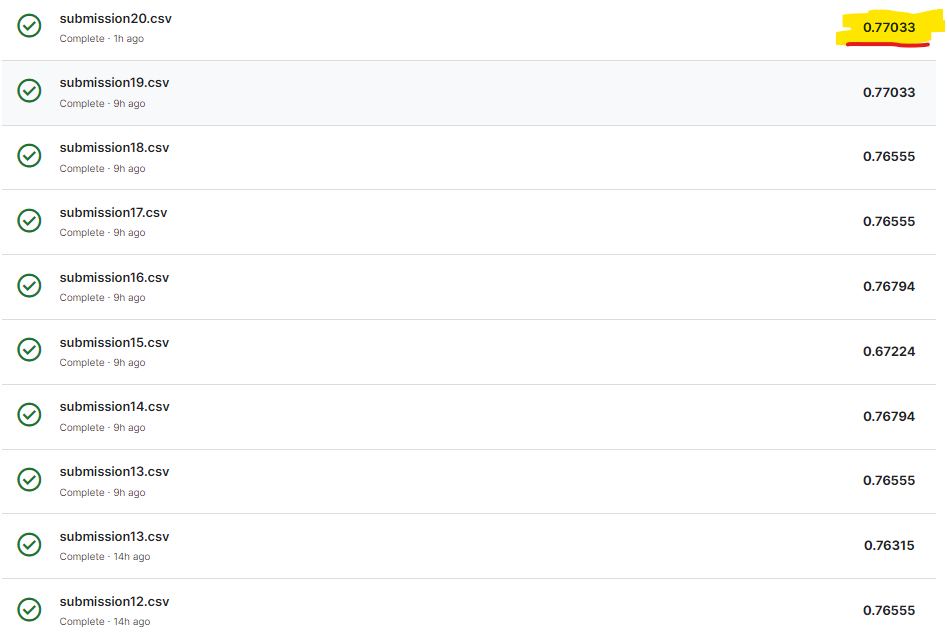

## In Conclusion

In this notebook, we embarked on the classic Kaggle Titanic survival prediction competition, aiming to apply various machine learning techniques to predict which passengers survived the tragedy. Throughout this analysis, we performed several key steps that contributed to our model's performance:

**Data Cleaning and Preprocessing**: We handled missing values, transformed categorical features, and normalized numerical features. This preprocessing ensured our models could effectively learn from the data without biases caused by inconsistent inputs.

**Exploratory Data Analysis (EDA)**: We thoroughly explored the dataset, identifying important features and patterns. This step was crucial in understanding the underlying structure and relationships within the data.

**Feature Engineering**: We created new family size feature by using two existing features- sibsp and parch, that helped us gain more insights and bettering our model.

**Model Selection and Evaluation**: We experimented with various machine learning algorithms, including logistic regression and SGD.
 We evaluated these models using cross-validation and performance metrics such as accuracy and log_loss.

**Hyperparameter Tuning**: By fine-tuning hyperparameters, we optimized model performance and ensured that our final model was both accurate and generalizable.

This project highlighted the importance of a systematic approach to data science, from initial exploration and preprocessing to model tuning and evaluation.

### References

During our research, we took inspiration from the lab exercises and lecture presentations available on Afeka College of Engineering organizational moodle, as well as some public notebooks available on Kaggle.<br>We referenced 'Medium' technical articles about Data science, and used python's libraries Docs and GPT's for technical aspect. We've also read some researchers papers about the titanic event to gain insights for our model.

Code documentaries we used:<br>
Scikit-Learn GridSearchCV documentary: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html<br>
Scikit-Learn LogisticRegression documentary: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br>
Scikit-Learn SGDClassifier documentary: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html<br>
Scikit-Learn StratifiedKFold documetary: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
Scikit-Learn StandardScaler documetary: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
Pandas DataFrame documentary: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html<br>
Matplotlib plotting examples: https://matplotlib.org/stable/gallery/lines_bars_and_markers/categorical_variables.html#sphx-glr-gallery-lines-bars-and-markers-categorical-variables-py
Matplotlib pie charts: https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html
Matplotlib Stacked bar chart: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html#sphx-glr-gallery-lines-bars-and-markers-bar-stacked-py

"Woman and children first" hypothesis : https://www.cbsnews.com/news/women-and-children-first-just-a-myth-researchers-say/
                                        https://en.wikipedia.org/wiki/Women_and_children_first<br>

Wikipedia article about the Titanic: https://en.wikipedia.org/wiki/Titanic
